In [3]:
suppressMessages({
    library(SummarizedExperiment)
    library(DESeq2)
    library(tidyverse)
    library(cowplot)
    library(ExploreModelMatrix)
    library(ComplexHeatmap)
})

In [37]:
counts = read.csv("combined.csv", row.names = 1)

In [38]:
sample_info = read.csv("poly_a_sample_list_duplicate.csv", row.names = 1)

In [39]:
# a is missleadeing (is globin clear from pbmc)
sample_info

,Gender,Ethnicity,Condition
,<chr>,<chr>,<chr>
HS_299,F,Caucasian,HS
HS_644,UNKOWN,UNKOWN,UNKOWN
HS_672,F,Caucasian,HS
HS_678,M,African American,HS
HS_694,F,African American,HS
HS_696,F,African American,HS
HS_698,F,African American,HS
HS_701,F,Caucasian,HS
HS_702,F,Caucasian,HS


In [40]:
sample_info$Globin <- grepl("a$", row.names(sample_info))

In [6]:
rownames(sample_info)

[1] "HS_299"   "HS_644"   "HS_672"   "HS_678"   "HS_694"   "HS_696"  
 [7] "HS_698"   "HS_701"   "HS_702"   "HS_703"   "HS_299_a" "HS_644_a"
[13] "HS_672_a" "HS_678_a" "HS_694_a" "HS_696_a" "HS_698_a" "HS_701_a"
[19] "HS_702_a" "HS_703_a"

In [41]:
index <- match(colnames(counts), rownames(sample_info))
sample_info = sample_info[index,]

In [42]:
annotation = read.csv('gencode.v46.primary_assembly.gene_annotation.txt', sep = ' ')

In [43]:
real_genes = filter(annotation, Gene_Biotype == "protein_coding" | Gene_Biotype == "lncRNA")$ENS_ID

In [44]:
real_counts = counts[real_genes,]

In [22]:
dim(real_counts)[1]/dim(annotation)[1]

[1] 0.6231707

In [45]:
se <- SummarizedExperiment(assays = list(counts = as.matrix(real_counts)),
                           colData = sample_info)

In [46]:
rowData(se)["gene_id"] = row.names(rowData(se))
rowData(se)$gene_id_reduced <- sub("\\..*", "", rowData(se)$gene_id)
row.names(se) = rowData(se)[["gene_id_reduced"]]

In [47]:
grch_symbols = read.csv("symbols.csv", row.names = 1)
common_indices <- intersect(rownames(rowData(se)), rownames(grch_symbols))

rowData(se)[common_indices,"symbol"] = grch_symbols[common_indices,"symbol"]

In [48]:
colData(se)["Patient"] = substr(row.names(colData(se)), 1, 6)

In [49]:
colData(se)$Patient = as.factor(colData(se)$Patient)
colData(se)$Globin = as.factor(colData(se)$Globin)

In [50]:
levels(colData(se)$Globin)

[1] "FALSE" "TRUE"

In [51]:
colData(se)

DataFrame with 20 rows and 5 columns
              Gender        Ethnicity   Condition   Globin  Patient
         <character>      <character> <character> <factor> <factor>
HS_299_a           F        Caucasian          HS     TRUE   HS_299
HS_644_a      UNKOWN           UNKOWN      UNKOWN     TRUE   HS_644
HS_672_a           F        Caucasian          HS     TRUE   HS_672
HS_678_a           M African American          HS     TRUE   HS_678
HS_694_a           F African American          HS     TRUE   HS_694
...              ...              ...         ...      ...      ...
HS_696             F African American          HS    FALSE   HS_696
HS_698             F African American          HS    FALSE   HS_698
HS_701             F        Caucasian          HS    FALSE   HS_701
HS_702             F        Caucasian          HS    FALSE   HS_702
HS_703             F        Caucasian          HS    FALSE   HS_703

In [52]:
row.names(se) = rowData(se)$symbol

In [53]:
rowData(se)

DataFrame with 39347 rows and 3 columns
                          gene_id gene_id_reduced          symbol
                      <character>     <character>     <character>
DDX11L2         ENSG00000290825.1 ENSG00000290825         DDX11L2
MIR1302-2HG     ENSG00000243485.5 ENSG00000243485     MIR1302-2HG
FAM138A         ENSG00000237613.2 ENSG00000237613         FAM138A
ENSG00000290826 ENSG00000290826.1 ENSG00000290826 ENSG00000290826
OR4F5           ENSG00000186092.7 ENSG00000186092           OR4F5
...                           ...             ...             ...
ENSG00000277836 ENSG00000277836.1 ENSG00000277836 ENSG00000277836
ENSG00000278633 ENSG00000278633.1 ENSG00000278633 ENSG00000278633
ENSG00000276017 ENSG00000276017.1 ENSG00000276017 ENSG00000276017
ENSG00000278817 ENSG00000278817.1 ENSG00000278817 ENSG00000278817
ENSG00000277196 ENSG00000277196.4 ENSG00000277196 ENSG00000277196

In [54]:
dds <- DESeqDataSet(se, design = ~ Globin + Patient)
dds <- estimateSizeFactors(dds)

Warning message in DESeqDataSet(se, design = ~Globin + Patient):
"64 duplicate rownames were renamed by adding numbers"


In [96]:
data.frame(sizeFactors(dds))

,sizeFactors.dds.
,<dbl>
HS_299_a,1.3665549
HS_644_a,1.1827352
HS_672_a,1.3075495
HS_678_a,1.0223829
HS_694_a,1.2334042
HS_696_a,1.6208892
HS_698_a,1.6514347
HS_701_a,1.5526481
HS_702_a,1.5225979


gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



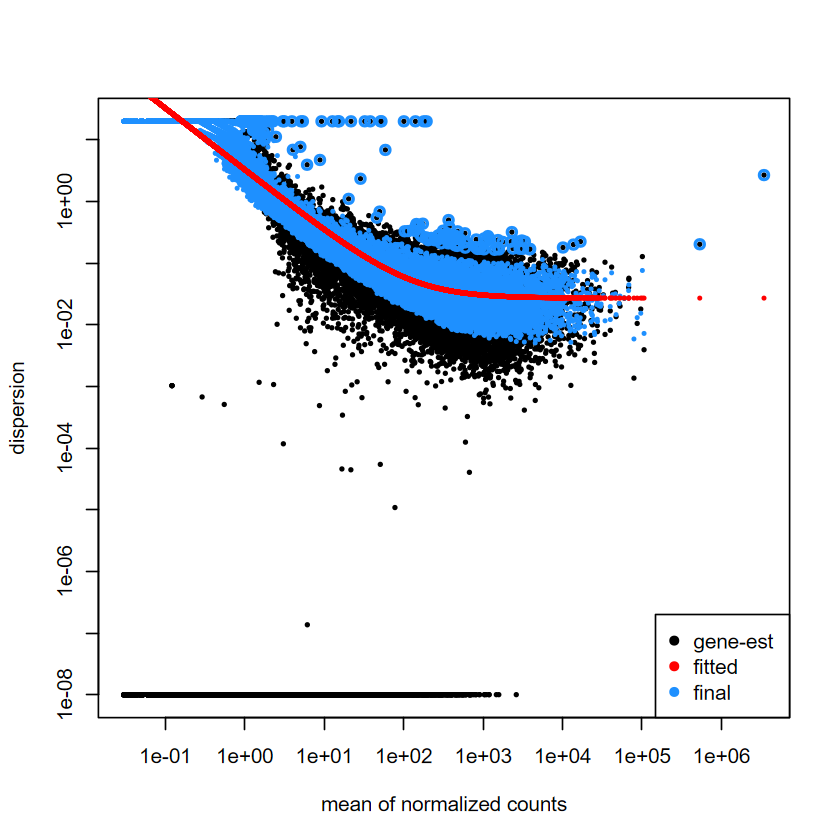

In [57]:
# Estimate dispersion parameter for negative binomial distribution
dds <- estimateDispersions(dds)
plotDispEsts(dds)
dds <- nbinomWaldTest(dds, maxit = 100)

In [35]:
res <- results(dds, contrast = c('Globin', 'TRUE', 'FALSE'))

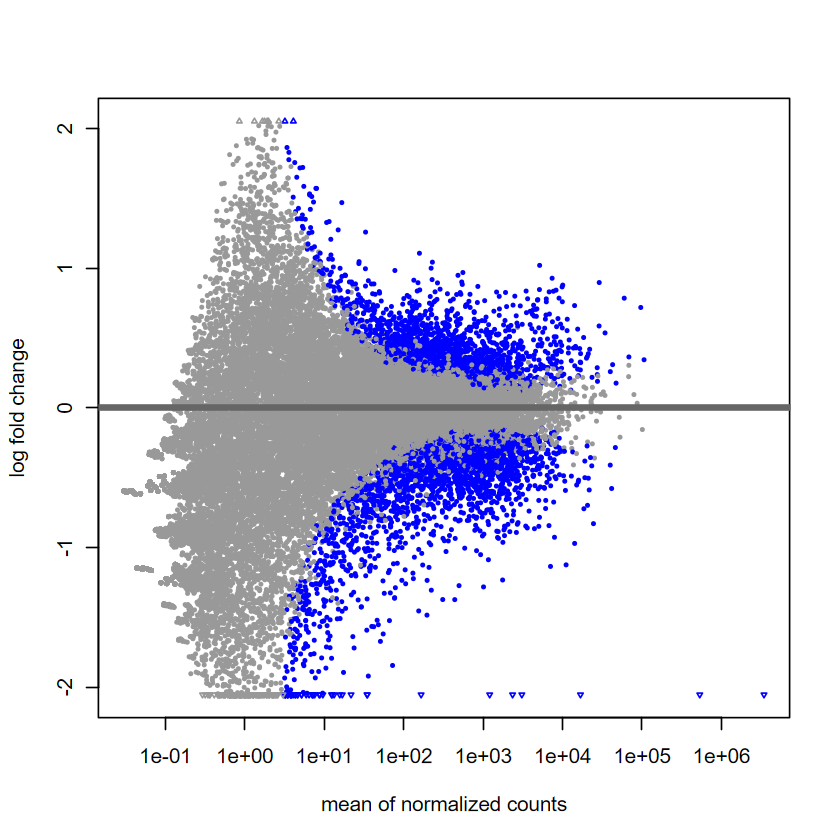

In [36]:
plotMA(res)

In [37]:
res

log2 fold change (MLE): Globin TRUE vs FALSE 
Wald test p-value: Globin TRUE vs FALSE 
DataFrame with 39347 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat    pvalue
                <numeric>      <numeric> <numeric>  <numeric> <numeric>
DDX11L2         8.4567451       0.222671  0.467106  0.4767039  0.633573
MIR1302-2HG     0.3247982      -0.114022  3.008239 -0.0379032  0.969765
FAM138A         0.0328386      -0.604342  3.025459 -0.1997522  0.841674
ENSG00000290826 0.0000000             NA        NA         NA        NA
OR4F5           0.0308473      -0.594372  3.025937 -0.1964258  0.844277
...                   ...            ...       ...        ...       ...
ENSG00000277836  0.961287      -0.332491  1.690377  -0.196696  0.844065
ENSG00000278633  0.000000             NA        NA         NA        NA
ENSG00000276017  0.000000             NA        NA         NA        NA
ENSG00000278817  3.512138       0.580154  0.715616   0.810706  0.417535
ENSG00000

In [38]:
# should filter res so you only include genes that exist in both globin and non-globin since you will have NAs for L2FC

common_genes = read.csv("common_genes_codinglnc.csv")
res_common = res[row.names(res) %in% common_genes$symbol,]

In [39]:
res_ordered = res_common[order(res_common$padj),]



library(openxlsx)

write.csv(res_ordered, file = "resordered_common.csv")

In [40]:
res_ordered

log2 fold change (MLE): Globin TRUE vs FALSE 
Wald test p-value: Globin TRUE vs FALSE 
DataFrame with 25865 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat       pvalue
                <numeric>      <numeric> <numeric> <numeric>    <numeric>
HBA2            534267.79     -11.121788 0.2911639  -38.1977  0.00000e+00
HBD               2354.82      -6.203585 0.1757545  -35.2969 6.55642e-273
HBA1             16843.99     -12.515479 0.3683840  -33.9740 5.39460e-253
TAF15             1212.18      -2.161412 0.1594404  -13.5562  7.27692e-42
MYH9             24542.69      -0.828551 0.0713173  -11.6178  3.34577e-31
...                   ...            ...       ...       ...          ...
ENSG00000277475  1.042911       0.832173   1.36925  0.607758     0.543348
ENSG00000275869  0.288194      -0.511868   3.01487 -0.169781     0.865182
ENSG00000273554  1.168111      -1.433263   1.41199 -1.015069     0.310073
ENSG00000277836  0.961287      -0.332491   1.69038 -0.19669

In [88]:
res_omit = na.omit(res)
res_filtered <- res_omit[res_omit$log2FoldChange > 0,]

# filter out the novel transcriptomes
res_filtered <- res_filtered[!grepl("^ENSG", row.names(res_filtered)), ]

In [89]:
library(EnhancedVolcano)
png("volcano_plot_globin_degs_codinglnc.png", width = 12, height = 8, units = "in", res = 300)

EnhancedVolcano(res_filtered,
    lab = row.names(res_filtered),
    x = 'log2FoldChange',
    y = 'padj',
    title = 'Globin Depleted DEGs',
    pCutoff = 10e-2
)

dev.off()

png 
  2

In [90]:
res_omit = na.omit(res)
res_filtered <- res_omit[-5 < res_omit$log2FoldChange & res_omit$log2FoldChange < 0,]
res_filtered <- res_filtered[!grepl("^ENSG", row.names(res_filtered)), ]

In [91]:
library(EnhancedVolcano)
png("volcano_plot_nonglobin_degs_codinglnc.png", width = 12, height = 8, units = "in", res = 300)

EnhancedVolcano(res_filtered,
    lab = row.names(res_filtered),
    x = 'log2FoldChange',
    y = 'padj',
    title = 'Non-Globin Depleted DEGs',
    pCutoff = 10e-2
)

dev.off()

png 
  2

In [92]:
library(ComplexHeatmap)

top_genes <- head(rownames(res_ordered), 50)
norm_counts <- counts(dds, normalized = TRUE)

# Subset the normalized counts for the top genes
top_norm_counts <- norm_counts[top_genes, ]

scaled_counts <- t(scale(t(top_norm_counts)))  # Scale by rows (genes)

col_data <- data.frame(GlobinDepletionStatus = factor(rep(c("Globin Depleted", "Non-Globin Depleted"), each = 10)))

# Define color palette for the groups
group_colors <- c("Globin Depleted" = "skyblue", "Non-Globin Depleted" = "salmon")

# Create HeatmapAnnotation
annotation <- HeatmapAnnotation(
  df = col_data,
  col = list(GlobinDepletionStatus = group_colors),
  show_annotation_name = TRUE,
  annotation_name_side = "right",
  annotation_name_gp = gpar(fontface = "bold"),
  gp = gpar(col = "black")
)

png("heatmap_plot.png", width = 8, height = 15, units = "in", res = 300)
# Create the heatmap
hm = Heatmap(scaled_counts,
        name = "Expression",
        show_row_names = TRUE,
        show_column_names = TRUE,
        cluster_rows = TRUE,   # Cluster genes
        cluster_columns = TRUE, # Cluster samples
        bottom_annotation = annotation
)

draw(hm,
   column_title="                                       Globin Depletion vs Non-Depletion Normalized Gene Expression",
   column_title_gp=grid::gpar(fontsize=16))



dev.off()

png 
  2

In [41]:
saveRDS(dds, "comp_dds_codinglnc.RDS")
saveRDS(res_common, "comp_res_common_codinglnc.RDS")

In [1]:
dds = readRDS("comp_dds.RDS")
res = readRDS("comp_res.RDS")

In [4]:
raw_counts = counts(dds, normalized=FALSE)

total_counts = colSums(raw_counts)

In [5]:
total_counts

HS_299_a HS_644_a HS_672_a HS_678_a HS_694_a HS_696_a HS_698_a HS_701_a 
16661582 16620978 16220056 18253299 16850168 19716396 18007289 17368869 
HS_702_a HS_703_a   HS_299   HS_644   HS_672   HS_678   HS_694   HS_696 
16141721 15811086 14255241 13612285 14857851 12499974 15426597 15875036 
  HS_698   HS_701   HS_702   HS_703 
15395967 13876479 13724937 12254633

In [35]:
Heme_genes = c("HBA1","HBA2","HBB","HBD","HBE1","HBG1","HBG2","HBM","HBQ1","HBZ")
heme_counts = colSums(raw_counts[Heme_genes,])
raw_counts[Heme_genes,]
heme_proportion = data.frame(heme_counts / total_counts)
names(heme_proportion) = 'proportion_count_hemoglobin_genes'
heme_proportion
heme_proportion["Depleted"] = grepl("a$", rownames(heme_proportion))
heme_proportion["total raw counts"] = total_counts

heme_proportion["hemoglobin counts"] = heme_counts
#write.csv(heme_proportion, "heme_prop.csv")
heme_proportion_gc = filter(heme_proportion, str_ends(row.names(heme_proportion), 'a'))
heme_proportion_ngc = filter(heme_proportion, !str_ends(row.names(heme_proportion), 'a'))
row.names(heme_proportion_gc) = substr(row.names(heme_proportion_gc), 1, nchar(row.names(heme_proportion_gc)) - 2)

heme_reduction = data.frame(
  pct_heme_reduction = (heme_proportion_ngc["proportion_count_hemoglobin_genes"] - 
                        heme_proportion_gc["proportion_count_hemoglobin_genes"]) / 
                        heme_proportion_ngc["proportion_count_hemoglobin_genes"]
)

names(heme_reduction) = "pct_heme_reduction"
heme_reduction

# We have 99% which is higher than advertised 95%
# https://www.thermofisher.com/order/catalog/product/AM1980

,HS_299_a,HS_644_a,HS_672_a,HS_678_a,HS_694_a,HS_696_a,HS_698_a,HS_701_a,HS_702_a,HS_703_a,HS_299,HS_644,HS_672,HS_678,HS_694,HS_696,HS_698,HS_701,HS_702,HS_703
HBA1,8,9,5,29,2,6,0,7,1,8,13914,18318,21678,51385,9270,12131,15557,24554,11211,13281
HBA2,480,1075,478,2481,297,500,87,905,353,332,705053,526807,514379,1310452,487393,359264,778198,927919,517639,531610
HBB,3359,24164,6530,10779,2754,8977,2707,7004,2277,3426,3635374,7538117,4487912,5943409,2770726,3810450,3882373,4535734,1202174,3010791
HBD,16,130,58,141,28,62,21,27,328,23,1207,5259,1702,4657,1545,1995,901,1464,8905,859
HBE1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HBG1,15,2174,15,81,12,439,0,1,2,123,6,794,12,20,8,276,0,3,3,50
HBG2,206,464,253,2396,177,117,30,127,127,9,183,286,225,776,305,108,8,92,205,18
HBM,2302,7917,4841,22488,1708,2676,1519,3780,1985,2560,1351,3996,2233,3162,1057,1778,2493,2130,1361,1452
HBQ1,581,1608,1359,6158,730,907,276,655,291,834,351,699,652,810,343,693,440,416,228,439
HBZ,0,0,0,60,1,7,0,0,5,4,24,2,3,82,30,11,1,0,23,23


,proportion_count_hemoglobin_genes
,<dbl>
HS_299_a,0.0004181476
HS_644_a,0.0022586517
HS_672_a,0.0008347074
HS_678_a,0.0024441061
HS_694_a,0.0003388097
HS_696_a,0.0006943967
HS_698_a,0.0002576734
HS_701_a,0.0007200239
HS_702_a,0.0003326163


,pct_heme_reduction
,<dbl>
HS_299,0.9986320
HS_644,0.9962016
HS_672,0.9975338
HS_678,0.9958233
HS_694,0.9984020
HS_696,0.9973670
HS_698,0.9991523
HS_701,0.9981808
HS_702,0.9973790


In [36]:
# repeat for main 3 globin genes
Heme_genes = c("HBA1","HBA2","HBB")
heme_counts = colSums(raw_counts[Heme_genes,])
raw_counts[Heme_genes,]
heme_proportion = data.frame(heme_counts / total_counts)
names(heme_proportion) = 'proportion_count_hemoglobin_genes'
heme_proportion
heme_proportion["Depleted"] = grepl("a$", rownames(heme_proportion))
heme_proportion["total raw counts"] = total_counts

heme_proportion["hemoglobin counts"] = heme_counts
#write.csv(heme_proportion, "heme_prop.csv")
heme_proportion_gc = filter(heme_proportion, str_ends(row.names(heme_proportion), 'a'))
heme_proportion_ngc = filter(heme_proportion, !str_ends(row.names(heme_proportion), 'a'))
row.names(heme_proportion_gc) = substr(row.names(heme_proportion_gc), 1, nchar(row.names(heme_proportion_gc)) - 2)

heme_reduction = data.frame(
  pct_heme_reduction = (heme_proportion_ngc["proportion_count_hemoglobin_genes"] - 
                        heme_proportion_gc["proportion_count_hemoglobin_genes"]) / 
                        heme_proportion_ngc["proportion_count_hemoglobin_genes"]
)

names(heme_reduction) = "pct_heme_reduction"
heme_reduction

# We have 99% which is higher than advertised 95%
# https://www.thermofisher.com/order/catalog/product/AM1980

,HS_299_a,HS_644_a,HS_672_a,HS_678_a,HS_694_a,HS_696_a,HS_698_a,HS_701_a,HS_702_a,HS_703_a,HS_299,HS_644,HS_672,HS_678,HS_694,HS_696,HS_698,HS_701,HS_702,HS_703
HBA1,8,9,5,29,2,6,0,7,1,8,13914,18318,21678,51385,9270,12131,15557,24554,11211,13281
HBA2,480,1075,478,2481,297,500,87,905,353,332,705053,526807,514379,1310452,487393,359264,778198,927919,517639,531610
HBB,3359,24164,6530,10779,2754,8977,2707,7004,2277,3426,3635374,7538117,4487912,5943409,2770726,3810450,3882373,4535734,1202174,3010791


,proportion_count_hemoglobin_genes
,<dbl>
HS_299_a,0.0002308904
HS_644_a,0.0015190442
HS_672_a,0.0004323660
HS_678_a,0.0007280328
HS_694_a,0.0001811851
HS_696_a,0.0004809703
HS_698_a,0.0001551594
HS_701_a,0.0004557579
HS_702_a,0.0001629938


,pct_heme_reduction
,<dbl>
HS_299,0.9992441
HS_644,0.9974419
HS_672,0.9987213
HS_678,0.9987543
HS_694,0.9991446
HS_696,0.9981742
HS_698,0.9994891
HS_701,0.9988477
HS_702,0.9987077


In [48]:
group_means <- heme_proportion %>%
  group_by(Depleted) %>%
  summarise(mean_proportion = mean(proportion_count_hemoglobin_genes, na.rm = TRUE))

group_means

Depleted,mean_proportion
<fct>,<dbl>
TRUE,0.0008762036
FALSE,0.3416750930


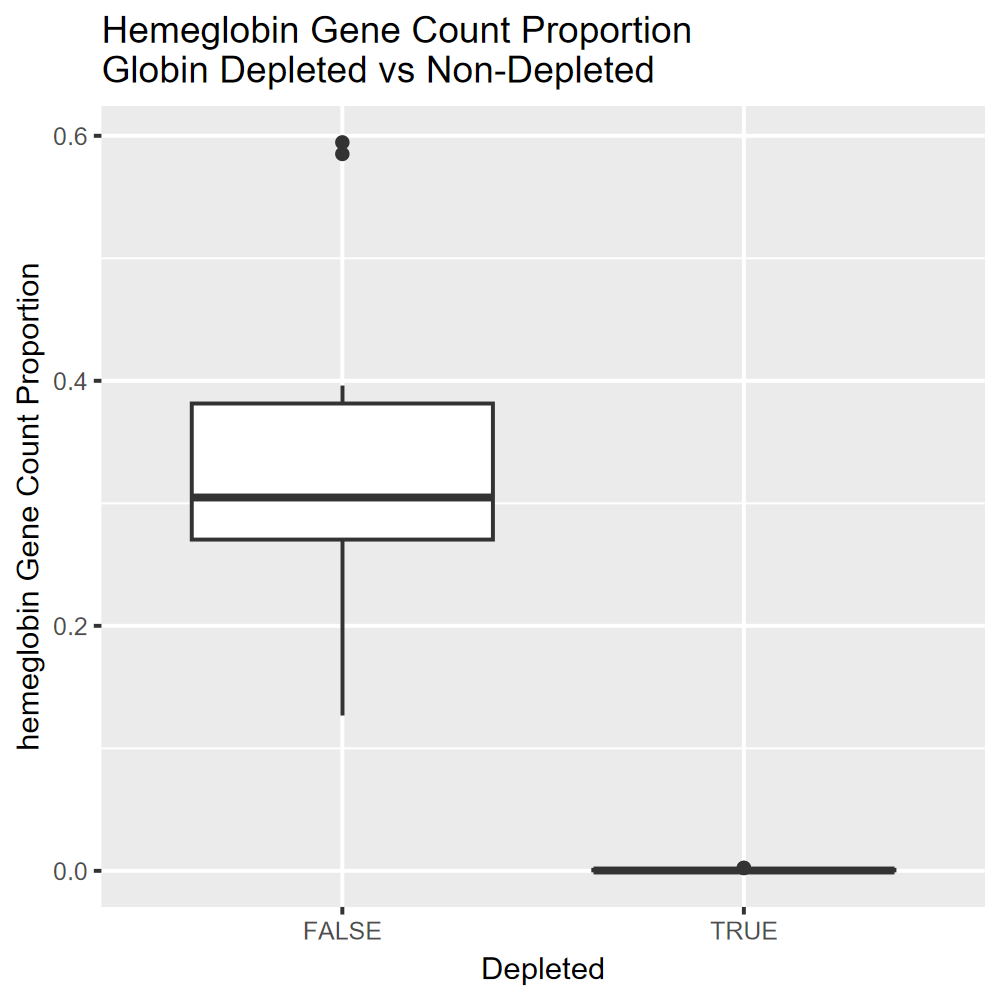

In [55]:
library(ggplot2)
heme_proportion$Depleted <- factor(heme_proportion$Depleted, levels = rev(levels(factor(heme_proportion$Depleted))))
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
# Assuming heme_proportion is your data frame and it has a column named "Depleted"
ggplot(heme_proportion, aes(x = Depleted, y = proportion_count_hemoglobin_genes)) +
  geom_boxplot() +
  labs(title = "Hemeglobin Gene Count Proportion\nGlobin Depleted vs Non-Depleted", x = "Depleted", y = "hemeglobin Gene Count Proportion")

In [88]:
summarize(group_by(df, globin), mean(non_zero_dge))

globin,mean(non_zero_dge)
<lgl>,<dbl>
FALSE,20385.9
TRUE,20101.9


Warning message in DESeqDataSet(se, design = ~Globin + Patient):
"64 duplicate rownames were renamed by adding numbers"


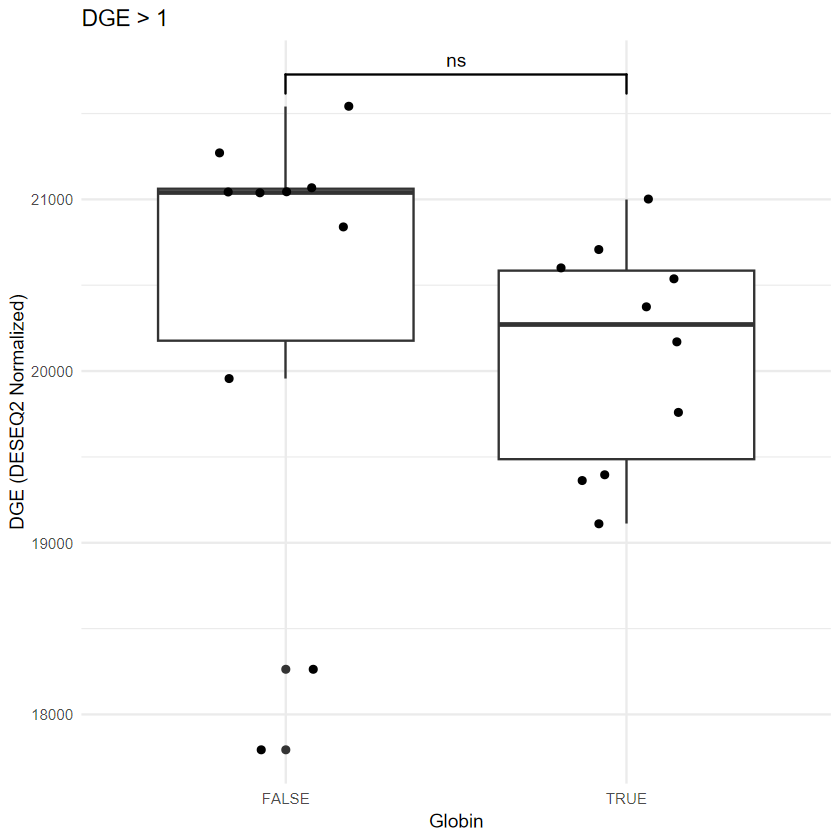

In [94]:
dds <- DESeqDataSet(se, design = ~ Globin + Patient)
dds <- estimateSizeFactors(dds)
normalized_counts = counts(dds, normalized = TRUE)
non_zero_dge = colSums(normalized_counts > 1)

df = data.frame(non_zero_dge)
df$globin = sapply(row.names(df), nchar) > 6

library(ggsignif)
p <- ggplot(df, aes(x = as.factor(globin), y = non_zero_dge)) +
  geom_boxplot() +
  geom_jitter(width = 0.2) +  # Add jitter for better visualization
  labs(x = "Globin", y = "DGE (DESEQ2 Normalized)", title = "DGE > 1") +
  theme_minimal()

# Perform t-test to get p-value
t_test <- t.test(non_zero_dge ~ globin, data = df)
p_value <- t_test$p.value

# Add significance bars
p + geom_signif(
  comparisons = list(c("TRUE", "FALSE")),
  map_signif_level = TRUE,
  annotations = ifelse(p_value < 0.05, "*", "ns")
)